# Figure 1: Motif type distribution

# Setup

In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from rna_motif_library.settings import DATA_PATH
from rna_motif_library.util import add_motif_indentifier_columns
from rna_motif_library.plotting import (
    publication_style_ax,
    calculate_subplot_coordinates,
    merge_sequential_coords,
)

PLOT_PATH = "../../figures/plots"

## extra functions


In [7]:
def add_residue_count(df: pd.DataFrame) -> pd.DataFrame:
    """Add a column counting non-gap residues in each sequence.

    Args:
        df: DataFrame containing motif data with 'msequence' column

    Returns:
        DataFrame with additional 'residue_num' column counting non-gap characters
    """
    df["residue_num"] = df["msequence"].str.replace("-", "").str.len()
    return df


def rename_motif_types(df):
    """Rename motif type values to more readable format.

    Args:
        df: DataFrame containing motif data

    Returns:
        DataFrame with renamed motif types
    """
    type_mapping = {
        "HELIX": "Helix",
        "SSTRAND": "Single Strand",
        "TWOWAY": "Two-way",
        "NWAY": "N-way",
        "HAIRPIN": "Hairpin",
    }

    df["motif_type"] = df["motif_type"].map(type_mapping)
    return df

## load data

In [8]:
path = "../../data/summaries/non_redundant_motifs_no_issues.csv"
df = pd.read_csv(path)
df = add_motif_indentifier_columns(df, "motif_name")
df = df.query("mtype != 'UNKNOWN'")
df = add_residue_count(df)
# Apply the renaming
df = rename_motif_types(df)

# Plots

## Figure 1a: Motif type counts

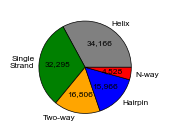

In [9]:
def figure_1a(df, ax):
    """Plot pie chart of motif type counts.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    colors = {
        "Helix": "gray",
        "N-way": "red",
        "Two-way": "orange",
        "Hairpin": "blue",
        "Single\nStrand": "green",
    }
    value_counts = df["motif_type"].value_counts()
    # Replace "Single Strand" with "Single\nStrand" in the index for plotting
    plot_index = value_counts.index.map(
        lambda x: "Single\nStrand" if x == "Single Strand" else x
    )
    value_counts.index = plot_index
    value_counts.plot(
        kind="pie",
        ax=ax,
        colors=[colors[m] for m in value_counts.index],
        wedgeprops={"edgecolor": "black", "linewidth": 0.5},
        autopct=lambda p: f"{int(p * len(df)/100):,}",
    )
    ax.set_ylabel("")
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5))
figure_1a(df, ax)

## Figure 1b: distribution of helix sizes

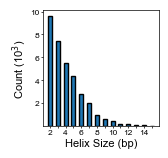

In [10]:
def get_helix_data(df):
    """Extract and process helix data from the main dataframe.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series: Value counts of helix sizes up to 15 bp
    """
    helices = df.query("motif_type == 'Helix'").copy()
    helices["msize"] = helices["msize"].astype(int)
    helix_sizes = helices["msize"].astype(int).value_counts()
    return helix_sizes[helix_sizes.index <= 15]  # Only keep sizes up to 15


def figure_1b(df, ax):
    """Plot bar chart of helix size distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get helices and their sizes
    helix_sizes = get_helix_data(df)

    # Create bar plot of helix sizes
    ax.bar(helix_sizes.index, helix_sizes.values, edgecolor="black", width=0.5)
    ax.set_xlabel("Helix Size (bp)", labelpad=2)
    # Set x-ticks to show every other value and label every other bar
    ax.set_xticks(helix_sizes.index)
    labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(helix_sizes.index)]
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_yticks([2000, 4000, 6000, 8000, 10000])
    ax.set_yticklabels(["2", "4", "6", "8", "10"])

    ax.set_ylabel("Count (10$^3$)", labelpad=1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5))
figure_1b(df, ax)

## Hairpin size distribution

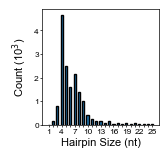

In [17]:
def get_hairpin_data(df):
    """Extract and process hairpin data from the main dataframe.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series: Value counts of hairpin sizes up to 25 nt
    """
    hairpins = df.query("motif_type == 'Hairpin'").copy()
    hairpins["msize"] = hairpins["msize"].astype(int)
    hairpins = hairpins.query("msize <= 25")
    hairpin_sizes = hairpins["msize"].value_counts().sort_index()
    return hairpin_sizes


def figure_1c(df, ax):
    """Plot bar chart of hairpin size distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get hairpins and their sizes
    hairpin_sizes = get_hairpin_data(df)

    # Create bar plot of hairpin sizes
    ax.bar(hairpin_sizes.index, hairpin_sizes.values, edgecolor="black", width=0.5)
    ax.set_xticks(hairpin_sizes.index)
    # Label every other bar
    labels = [str(x) if i % 3 == 0 else "" for i, x in enumerate(hairpin_sizes.index)]
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks([0, 1000, 2000, 3000, 4000])
    ax.set_yticklabels(["0", "1", "2", "3", "4"])
    ax.set_ylabel("Count (10$^3$)", labelpad=4)
    ax.set_xlabel("Hairpin Size (nt)", labelpad=2)

    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5))
figure_1c(df, ax)

## Single strand size distribution

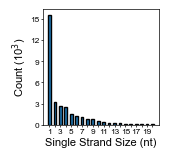

In [18]:
def get_single_strand_data(df):
    """Get single strand size distribution data.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series: Value counts of single strand sizes up to 25 nt
    """
    singles = df.query("mtype == 'SSTRAND'").copy()
    singles["msize"] = singles["msize"].astype(int)
    singles = singles.query("msize <= 20")
    single_sizes = singles["msize"].value_counts().sort_index()
    return single_sizes


def figure_1d(df, ax):
    """Plot bar chart of single strand size distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get single strands and their sizes
    single_sizes = get_single_strand_data(df)

    # Create bar plot of single strand sizes
    ax.bar(single_sizes.index, single_sizes.values, edgecolor="black", width=0.5)
    ax.set_xticks(single_sizes.index)
    ax.set_xlabel("Single Strand Size (nt)", labelpad=2)

    # Label every other bar
    labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(single_sizes.index)]
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks([0, 3000, 6000, 9000, 12000, 15000])
    ax.set_yticklabels(["0", "3", "6", "9", "12", "15"])

    ax.set_ylabel("Count (10$^3$)", labelpad=1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.5, 1.5))
figure_1d(df, ax)

In [13]:
# Calculate cumulative counts for single strand sizes
single_sizes = get_single_strand_data(df)
cumulative_counts = single_sizes.sort_index().cumsum()
print(cumulative_counts / single_sizes.sum())

msize
1     0.492447
2     0.594563
3     0.677253
4     0.754486
5     0.804283
6     0.841338
7     0.876155
8     0.903214
9     0.927055
10    0.944148
11    0.955596
12    0.965436
13    0.972973
14    0.979501
15    0.984579
16    0.988868
17    0.991548
18    0.994576
19    0.997729
20    1.000000
Name: count, dtype: float64


## Two-way junction size distribution

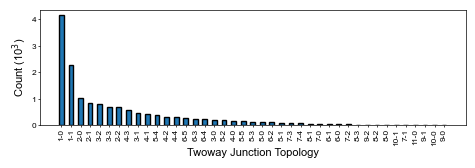

In [21]:
def get_twoway_data(df):
    """Get two-way junction data and their sizes.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series containing two-way junction size counts
    """
    twoways = df.query("motif_type == 'Two-way'").copy()
    twoways = add_residue_count(twoways)
    twoways = twoways.query("residue_num <= 15")
    twoway_sizes = twoways["msize"].value_counts()
    return twoway_sizes


def figure_1e(df, ax):
    """Plot bar chart of two-way junction size distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get two-way junctions and their sizes
    twoway_sizes = get_twoway_data(df)

    # Create bar plot of twoway sizes
    ax.bar(twoway_sizes.index, twoway_sizes.values, edgecolor="black", width=0.5)
    ax.set_xticks(twoway_sizes.index)
    ax.set_xlabel("Twoway Junction Topology", labelpad=2)

    # Label every bar
    labels = [str(x) for x in twoway_sizes.index]
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks([0, 1000, 2000, 3000, 4000])
    ax.set_yticklabels(["0", "1", "2", "3", "4"])

    # Remove tick marks
    ax.tick_params(axis="x", size=0)

    ax.set_ylabel("Count (10$^3$)", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


# Create the plot
fig, ax = plt.subplots(figsize=(5.5, 1.5))
figure_1e(df, ax)

## N-way junction strand count distribution

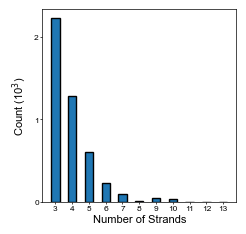

In [24]:
def get_nway_data(df):
    """Get N-way junction strand count data.

    Args:
        df: DataFrame containing motif data

    Returns:
        Series containing N-way junction strand counts
    """
    nways = df.query("motif_type == 'N-way'").copy()
    # Count number of strands by counting "-" in sequence and adding 1
    nways["num_strands"] = nways["msequence"].str.count("-") + 1
    strand_counts = nways["num_strands"].value_counts().sort_index()
    return strand_counts


def figure_1f(df, ax):
    """Plot bar chart of N-way junction strand count distribution.

    Args:
        df: DataFrame containing motif data
        ax: matplotlib axis to plot on
    """
    # Get N-way junctions and their strand counts
    strand_counts = get_nway_data(df)

    # Create bar plot of strand counts
    ax.bar(strand_counts.index, strand_counts.values, edgecolor="black", width=0.5)
    ax.set_xticks(strand_counts.index)
    ax.set_xlabel("Number of Strands", labelpad=2)

    # Label every bar since there will be fewer bars
    ax.set_xticklabels([str(x) for x in strand_counts.index], rotation=0)
    ax.set_ylabel("Count (10$^3$)", labelpad=4)
    ax.set_yticks([0, 1000, 2000])
    ax.set_yticklabels(["0", "1", "2"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


# Create the plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
figure_1f(df, ax)

## Final Figure

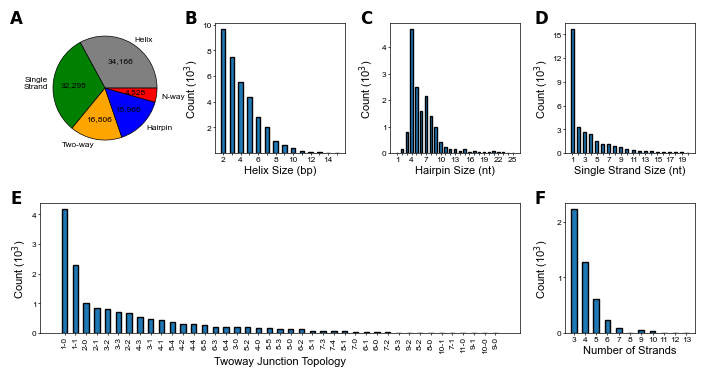

In [23]:
fig_size = (7, 4)
layout = (2, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.30, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
# combine subplots 4, 5, and 6 into one subplot
coords_list = merge_sequential_coords(coords_list, 4, 6)

fig = plt.figure(figsize=(7, 4), dpi=100)

# Create subplots
ax1 = fig.add_axes(coords_list[0])
figure_1a(df, ax1)

ax2 = fig.add_axes(coords_list[1])
figure_1b(df, ax2)

ax3 = fig.add_axes(coords_list[2])
figure_1c(df, ax3)

ax4 = fig.add_axes(coords_list[3])
figure_1d(df, ax4)

ax5 = fig.add_axes(coords_list[4])
figure_1e(df, ax5)

ax6 = fig.add_axes(coords_list[-1])
figure_1f(df, ax6)


# Usage:
# draw_box_around_subplot(
#    fig, coords_list[0], linewidth=1, edgecolor="red", facecolor="none"
# )
# draw_box_around_subplot(
#    fig, coords_list[1], linewidth=1, edgecolor="blue", facecolor="none"
# )
# draw_box_around_subplot(
#    fig, coords_list[2], linewidth=1, edgecolor="green", facecolor="none"
# )
# draw_box_around_subplot(
#    fig, coords_list[3], linewidth=1, edgecolor="orange", facecolor="none"
# )

# draw_box_around_figure(fig, linewidth=2, edgecolor="black")

# add_text_inches(fig, fig_width, fig_height, 0.1, 0.1, "A", fontsize=12, weight="bold")
letters = ["A", "B", "C", "D", "E", "F"]
for i, letter in enumerate(letters):
    fig.text(
        coords_list[i][0] - 0.3 / fig_size[0],
        coords_list[i][1] + 1.3 / fig_size[1],
        letter,
        fontsize=12,
        weight="bold",
    )


plt.show()
fig.savefig(os.path.join(PLOT_PATH, "Figure_1.png"), dpi=600)